In [1]:
import torch
import torch.nn as nn
import torchsummary
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

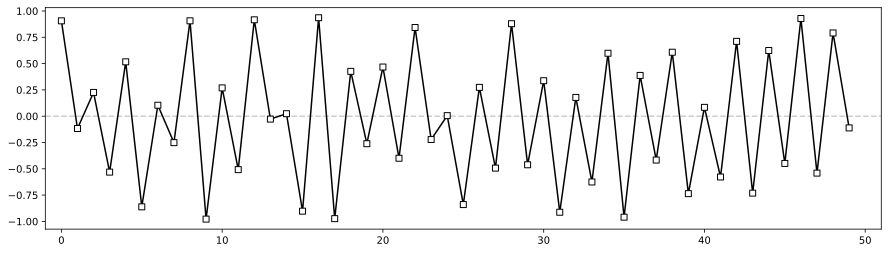

In [2]:
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15, 4))
plt.plot([-1, N+1], [0, 0], "--", color=[.8, .8, .8])
plt.plot(data, "ks-", markerfacecolor="w")
plt.xlim([-1, N+1])
plt.show()

In [3]:
class RNNnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # Linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        y, hidden = self.rnn(x)
        y = self.out(y)
        return y, hidden

In [4]:
input_size = 1 # "channels of data"
num_hidden = 5 # breadth of model
num_layers = 1 # depth of model
seq_length = 9 # number of data points used for learning each segment
batch_size = 1

net = RNNnet(input_size, num_hidden, num_layers)

x = torch.rand(seq_length, batch_size, input_size)
y_pred, h = net(x)

print(x.shape)
print(y_pred.shape) # 1 output per sequence element; generally we take the last
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [5]:
some_data = data[:seq_length].view(seq_length, 1, input_size)
y_pred = net(some_data)
final_val = y_pred[0][-1]
lossfunc = nn.MSELoss()
loss = lossfunc(final_val, data[seq_length].view(1, input_size))
print(loss)

tensor(0.4012, grad_fn=<MseLossBackward0>)


In [ ]:
epochs = 30

net = RNNnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

losses = np.zeros(epochs)
signal_acc = np.zeros(epochs)

for epochi in range(epochs):
    seg_losses = []
    seg_acc = []
    hidden_state = torch.zeros(num_layers, batch_size, num_hidden)

    for i in range(N-seq_length):
        x = data[i:i+seq_length].view(seq_length, batch_size, input_size)
        y = data[i+seq_length].view(batch_size, input_size)

        y_pred, hidden_state = net(x)
        final_val = y_pred[-1]
        loss = lossfunc(final_val, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        seg_losses.append(loss.item())
        true_sign = np.sign(torch.squeeze(y).numpy())
        pred_sign = np.sign(torch.squeeze(final_val).detach().numpy())
        seg_acc.append(100*(true_sign==pred_sign))
    
    losses[epochi] = np.mean(seg_losses)
    signal_acc[epochi] = np.mean(seg_acc)

    print(f"Epoch:{epochi+1}, Loss:{losses[epochi]:.2f}, Sig_Acc:{signal_acc[epochi]:.2f}")

Epoch:1, Loss:0.42, Sig_Acc:51.22
Epoch:2, Loss:0.40, Sig_Acc:51.22
Epoch:3, Loss:0.38, Sig_Acc:51.22
Epoch:4, Loss:0.36, Sig_Acc:51.22
Epoch:5, Loss:0.34, Sig_Acc:51.22
Epoch:6, Loss:0.33, Sig_Acc:51.22
Epoch:7, Loss:0.31, Sig_Acc:73.17
Epoch:8, Loss:0.30, Sig_Acc:87.80
Epoch:9, Loss:0.29, Sig_Acc:100.00
Epoch:10, Loss:0.27, Sig_Acc:100.00
Epoch:11, Loss:0.26, Sig_Acc:100.00
Epoch:12, Loss:0.25, Sig_Acc:100.00
Epoch:13, Loss:0.24, Sig_Acc:100.00
Epoch:14, Loss:0.23, Sig_Acc:100.00
Epoch:15, Loss:0.22, Sig_Acc:100.00
Epoch:16, Loss:0.21, Sig_Acc:100.00
Epoch:17, Loss:0.20, Sig_Acc:100.00
Epoch:18, Loss:0.19, Sig_Acc:100.00
Epoch:19, Loss:0.18, Sig_Acc:100.00
Epoch:20, Loss:0.18, Sig_Acc:100.00
Epoch:21, Loss:0.17, Sig_Acc:100.00
Epoch:22, Loss:0.16, Sig_Acc:100.00
Epoch:23, Loss:0.16, Sig_Acc:100.00
Epoch:24, Loss:0.15, Sig_Acc:100.00
Epoch:25, Loss:0.15, Sig_Acc:100.00
Epoch:26, Loss:0.14, Sig_Acc:100.00
Epoch:27, Loss:0.14, Sig_Acc:100.00
Epoch:28, Loss:0.14, Sig_Acc:100.00
Epoch:29,

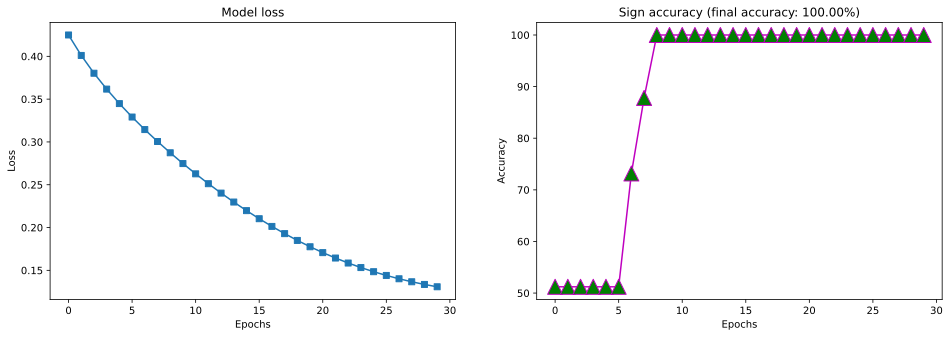

In [7]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signal_acc,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signal_acc[-1])

plt.show()